# Evaluation of fidelity, utility, and privacy aspects of synthetic data sets
---
The goal of this notebook is to utilize a synthetic data generation tool to create synthetic tabular data. Afterward, the synthetic data’s fidelity, utility, and privacy aspects should be evaluated. However, already existing tools should be leveraged and not implemented in any way. Therefore the assignment primarily involves leveraging existing code and implementing necessary
boilerplate code to get some results.

This project was carried out for the course 194.055 VU Security, Privacy and Explainability in Machine Learning at TU Wien.

## Packages
For this notebook to run properly, we need to install the required packages

In [1]:
%pip install -r ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


## General data & imports
In this section we define globally used variables and import the most used packages.

In [2]:
import numpy as np
import pandas as pd

from utils import train_and_evaluate

In [3]:
# define a random state
random_state = 12014500

# set the random state
np.random.seed(random_state)

## Dataset
In this notebook, we perform all action on the COMPASS-dataset. For our usecase we use the un-preprocessed version of it (./compass-scores-raw.csv). Therefore the following cells give a brief insight into the data itself.

In [4]:
file_path = './data/compas-scores-raw.csv'
df = pd.read_csv(file_path)

In [5]:
display(df.head())

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [6]:
df.shape

(60843, 28)

In [7]:
df.dtypes

Person_ID                    int64
AssessmentID                 int64
Case_ID                      int64
Agency_Text                 object
LastName                    object
FirstName                   object
MiddleName                  object
Sex_Code_Text               object
Ethnic_Code_Text            object
DateOfBirth                 object
ScaleSet_ID                  int64
ScaleSet                    object
AssessmentReason            object
Language                    object
LegalStatus                 object
CustodyStatus               object
MaritalStatus               object
Screening_Date              object
RecSupervisionLevel          int64
RecSupervisionLevelText     object
Scale_ID                     int64
DisplayText                 object
RawScore                   float64
DecileScore                  int64
ScoreText                   object
AssessmentType              object
IsCompleted                  int64
IsDeleted                    int64
dtype: object

In [8]:
df.isna().sum()

Person_ID                      0
AssessmentID                   0
Case_ID                        0
Agency_Text                    0
LastName                       0
FirstName                      0
MiddleName                 45195
Sex_Code_Text                  0
Ethnic_Code_Text               0
DateOfBirth                    0
ScaleSet_ID                    0
ScaleSet                       0
AssessmentReason               0
Language                       0
LegalStatus                    0
CustodyStatus                  0
MaritalStatus                  0
Screening_Date                 0
RecSupervisionLevel            0
RecSupervisionLevelText        0
Scale_ID                       0
DisplayText                    0
RawScore                       0
DecileScore                    0
ScoreText                     45
AssessmentType                 0
IsCompleted                    0
IsDeleted                      0
dtype: int64

In [9]:
df.describe()

,Person_ID,AssessmentID,Case_ID,ScaleSet_ID,RecSupervisionLevel,Scale_ID,RawScore,DecileScore,IsCompleted,IsDeleted
count,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.0,60843.0
mean,53683.206154,68061.029190,60209.128149,21.819536,1.630048,11.000000,5.081457,3.571701,1.0,0.0
std,14363.648515,7320.208226,9638.501654,0.932614,0.944220,4.966596,10.080518,2.617854,0.0,0.0
min,656.000000,649.000000,350.000000,17.000000,1.000000,7.000000,-4.790000,-1.000000,1.0,0.0
25%,52039.000000,62582.000000,56021.000000,22.000000,1.000000,7.000000,-2.090000,1.000000,1.0,0.0
50%,57321.000000,68229.000000,61261.000000,22.000000,1.000000,8.000000,-0.710000,3.000000,1.0,0.0
75%,62748.000000,73870.000000,66554.000000,22.000000,2.000000,18.000000,14.000000,5.000000,1.0,0.0
max,68608.000000,79678.000000,72045.000000,22.000000,4.000000,18.000000,51.000000,10.000000,1.0,0.0


### PreProcessing
This sections deals, with the pre-processing we performed on the dataset.

In [10]:
nominal_features = ['Agency_Text', 'Ethnic_Code_Text', 'AssessmentReason', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'RecSupervisionLevel']
target = 'ScoreText'

First, we dropped all features, that either had redundant information, like `DisplayText` being the textual version of `Scale_ID`, or directly identifying informations like any kind of unique ids or names.

In [11]:
columns_to_drop = ['Person_ID', 'AssessmentID', 'Case_ID', 'LastName', 'FirstName', 'MiddleName', 'ScaleSet', 'RecSupervisionLevelText', 'DisplayText', 'RawScore', 'DecileScore', 'AssessmentType', 'IsCompleted', 'IsDeleted'] 
df = df.drop(columns_to_drop, axis=1)

Furthermore, we converted `Sex_Code_Text` to binary to make calculations easier and converted `DateOfBirth` and `Screening_Date` to Unix timestamp to make it workable with our classifers in the end.

In [12]:
df['Sex_Code_Text'] = df['Sex_Code_Text'].apply(lambda x: 1 if x == 'Male' else 0)
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth']).astype(int) // 10**9  # Convert to Unix timestamp
df['Screening_Date'] = pd.to_datetime(df['Screening_Date']).astype(int) // 10**9  # Convert to Unix timestamp

Afterwards, we removed all records that had missing values in our label attribute `ScoreText`. Those records cannot be used in any way and therefore should be discarded.

In [13]:
df = df.dropna(subset=['ScoreText'])

Now, we only select one kind of score to evaluate, to make further analysis rather simple.

In [14]:
df = df[df['Scale_ID'] == 8]

In [15]:
df.shape

(20245, 14)

#### Train/Test-Split
After this we perform the basic 80/20 split into train and test data.

In [16]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

Lastly, we replaces all `NaN`-strings inside the train- and test-set individually with `np.nan` to make it more unified.

In [17]:
df_train.replace('NaN', np.nan, inplace=True)
df_test.replace('NaN', np.nan, inplace=True)

## Baseline Classifier
This sections simply trains and evaluates our baseline. We simply use a Random Forests because it should be an easy but robust classifier.

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, df_train, df_test, nominal_features, target)

{'accuracy': 0.8930600148184737,
 'precision': 0.904302925004072,
 'recall': 0.8650157431975405,
 'f1': 0.8735628868868163}

## Data synthetization
This sections presents the creation and evaluation of our synthesized data. For this we use multiple instances from the [Synthetic Data Vault](https://github.com/sdv-dev/SDV) and two methods from [DataSynthesizer](https://github.com/DataResponsibly/DataSynthesizer). We only synthesize the training data, because we want to further evaluate on original test data.

#### Synthetic Data Vault

In [19]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import CopulaGANSynthesizer

from utils import generate_synthetic_data, evaluate_privacy_risks, evaluate_inference_risks

### Metadata
First, of all we need to create a metadata object of our training data. This simply is a representation of our data.

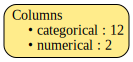

In [37]:
metadata = SingleTableMetadata()

try: 
    metadata = metadata.load_from_json('./synthesizers/metadata.json')
except: 
    metadata.detect_from_dataframe(df_train)
    metadata.save_to_json(filepath='./synthesizers/metadata.json')

metadata.visualize(
    show_table_details='summarized',
    output_filepath='./images/my_metadata.png'
)

Afterwards, we validate the metadata to ensure that it is correct.

In [38]:
metadata.validate_data(data=df_train)

### GaussianCopulaSynthesizer

In [40]:
synthetic_data_gc = generate_synthetic_data(GaussianCopulaSynthesizer(metadata, enforce_min_max_values=True), df_train, fit=False)

In [41]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_gc,metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 760.12it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 1249.79it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [42]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(real_data=df_train, synthetic_data=synthetic_data_gc, metadata=metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 228.32it/s]|
Column Shapes Score: 96.52%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 63.23it/s]|
Column Pair Trends Score: 70.37%

Overall Score (Average): 83.45%



In [43]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Agency_Text,TVComplement,0.998518
1,Sex_Code_Text,TVComplement,0.996110
2,Ethnic_Code_Text,TVComplement,0.991479
3,DateOfBirth,KSComplement,0.589899
4,ScaleSet_ID,TVComplement,0.999321
5,AssessmentReason,TVComplement,1.000000
6,Language,TVComplement,0.999383
7,LegalStatus,TVComplement,0.997469
8,CustodyStatus,TVComplement,0.997715
9,MaritalStatus,TVComplement,0.991665


In [45]:
quality_report.get_visualization(property_name='Column Pair Trends')

#### Classifier

In [46]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_gc, df_test, nominal_features, target)

{'accuracy': 0.7540133366263275,
 'precision': 0.7197384058509758,
 'recall': 0.645978873395046,
 'f1': 0.6637658434151851}

In [47]:
evaluate_privacy_risks(df_train, synthetic_data_gc)

{'univariate': PrivacyRisk(value=0.002909552484292007, ci=(0.00017654637062607809, 0.0056425585979579355)),
 'multivariate': PrivacyRisk(value=0.03578326945426869, ci=(0.024431348663226313, 0.04713519024531107))}

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.32068881652739994, baseline = 0.3475854940482899. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9901172348251068, baseline = 0.9941019277911646. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.55777

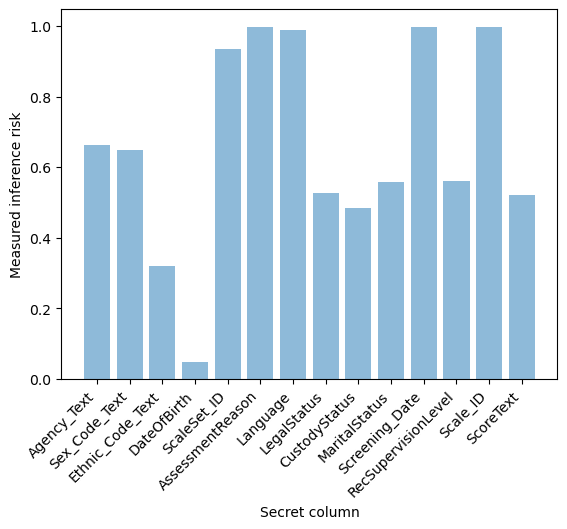

In [48]:
evaluate_inference_risks(df_train, synthetic_data_gc)